# Norway invasive species  

## Data Preprocessing for Machine Learning

In [1]:
import pandas as pd
import numpy as np

# === Load data ===
df = pd.read_csv("assess.txt", sep=";", encoding="latin1", na_values="NA")

# Drop unnecessary columns (2–6 and Status, like before)
drop_cols = list(df.columns[1:6]) + ["Status"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Clean column names (remove spaces)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# === Encode Impact ===
impact_order = {"NK": 0, "LO": 1, "PH": 2, "HI": 3, "SE": 4}
df["Impact_num"] = df["Impact"].map(impact_order)
df["Impact_num"] = df["Impact_num"].astype("Int64")  # Nullable integer type

# === Helper function for multi-label encoding ===
def make_dummies(df, col, prefix):
    """Split comma-separated strings into 0/1 dummy matrix."""
    s = df[col].fillna("").astype(str).str.replace(r"\s+", "", regex=True)
    dummies = s.str.get_dummies(sep=",")
    dummies.columns = [f"{prefix}{c}" for c in dummies.columns]
    return dummies

# === Encode categorical multi-label columns ===

## Origins & Current Distribution
origin_dummies = make_dummies(df, "Origin", "Origin_")
curdis_dummies = make_dummies(df, "CurDis", "CurDis_")

## Combine both pathways before dummy encoding
path_combined = (
    df[["Pathw1", "Pathw2"]]
    .fillna("")
    .apply(lambda x: ",".join([v for v in x if v]), axis=1)
)
path_dummies = path_combined.str.replace(r"\s+", "", regex=True).str.get_dummies(sep=",")
path_dummies.columns = [f"Path_{c}" for c in path_dummies.columns]

## Lifestyle & Ecosystem
life_dummies = make_dummies(df, "LifeSt", "Life_")
eco_dummies = make_dummies(df, "Ecosys", "Eco_")

# === Merge everything back ===
df_ml = pd.concat(
    [
        df,
        origin_dummies,
        curdis_dummies,
        path_dummies,
        life_dummies,
        eco_dummies
    ],
    axis=1
)

# Drop original text columns
df_ml = df_ml.drop(
    columns=["Origin", "CurDis", "Pathw1", "Pathw2", "LifeSt", "Ecosys"],
    errors="ignore"
)

# Fill missing numeric values with 0
df_ml = df_ml.fillna(0)

# === Verify the result ===
print("✅ Data preprocessing complete!")
print(f"Shape: {df_ml.shape}")
df_ml.head()

✅ Data preprocessing complete!
Shape: (1532, 217)


,Name,Class,Phylum,Kingd,Mainl,Observ,AOO,Imp12,Impact,minImp,...,Eco_VU-04,Eco_VU-05,Eco_VU-06,Eco_VU-07,Eco_VU-08,Eco_VU-09,Eco_VU-10,Eco_VU-11,Eco_VU-12,Eco_VU-13
0,Abies amabilis,Pinopsida,Pinophyta,Plantae,True,2012.0,40,NR,NK,NK,...,0,0,0,0,0,0,0,0,0,0
1,Abies balsamea,Pinopsida,Pinophyta,Plantae,True,1850.0,512,LO,LO,LO,...,0,0,0,0,0,0,0,0,0,0
2,Abies cephalonica,Pinopsida,Pinophyta,Plantae,True,2005.0,120,NR,LO,LO,...,0,0,0,0,0,0,0,0,0,0
3,Abies concolor,Pinopsida,Pinophyta,Plantae,True,1875.0,1000,PH,PH,LO,...,0,0,0,0,0,0,0,0,0,0
4,Abies grandis,Pinopsida,Pinophyta,Plantae,True,1890.0,240,PH,LO,LO,...,0,0,0,0,0,0,0,0,0,0


## Data visualization and unsupervised exploration

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

In [4]:

# --- Count summaries for each main category ---
origin_counts = df_ml.filter(like="Origin_").sum().sort_values(ascending=False)
curdis_counts = df_ml.filter(like="CurDis_").sum().sort_values(ascending=False)
path_counts = df_ml.filter(like="Path_").sum().sort_values(ascending=False)
life_counts = df_ml.filter(like="Life_").sum().sort_values(ascending=False)
eco_counts = df_ml.filter(like="Eco_").sum().sort_values(ascending=False)

# --- Plot setup ---
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()
sns.set(style="whitegrid", font_scale=1.1)

# --- 1. Impact ---
sns.countplot(data=df_ml, x="Impact", order=["NK", "LO", "PH", "HI", "SE"], palette="magma", ax=axes[0])
axes[0].set_title("Impact Categories", fontsize=13)

# --- 2. Phylum ---
sns.countplot(data=df_ml, y="Phylum", order=df_ml["Phylum"].value_counts().index, palette="viridis", ax=axes[1])
axes[1].set_title("Phylum Distribution", fontsize=13)

# --- 3. Top 10 Origins ---
sns.barplot(x=origin_counts.head(10), y=origin_counts.head(10).index, palette="crest", ax=axes[2])
axes[2].set_title("Top 10 Origins", fontsize=13)

# --- 4. Top 10 Current Distributions ---
sns.barplot(x=curdis_counts.head(10), y=curdis_counts.head(10).index, palette="flare", ax=axes[3])
axes[3].set_title("Top 10 Current Distributions", fontsize=13)

# --- 5. Top 10 Pathways ---
sns.barplot(x=path_counts.head(10), y=path_counts.head(10).index, palette="rocket", ax=axes[4])
axes[4].set_title("Top 10 Pathways", fontsize=13)

# --- 6. Top 10 Ecosystems ---
sns.barplot(x=eco_counts.head(10), y=eco_counts.head(10).index, palette="coolwarm", ax=axes[5])
axes[5].set_title("Top 10 Ecosystems", fontsize=13)

# --- Styling ---
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

plt.tight_layout()
plt.show()

NameError: name 'df_ml' is not defined

/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -4.421202308589213 whereas the largest positive one is 187.05660070400637.
  warn(
/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -10.052866106839522 whereas the largest positive one is 181.53862911274783.
  warn(
/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenv

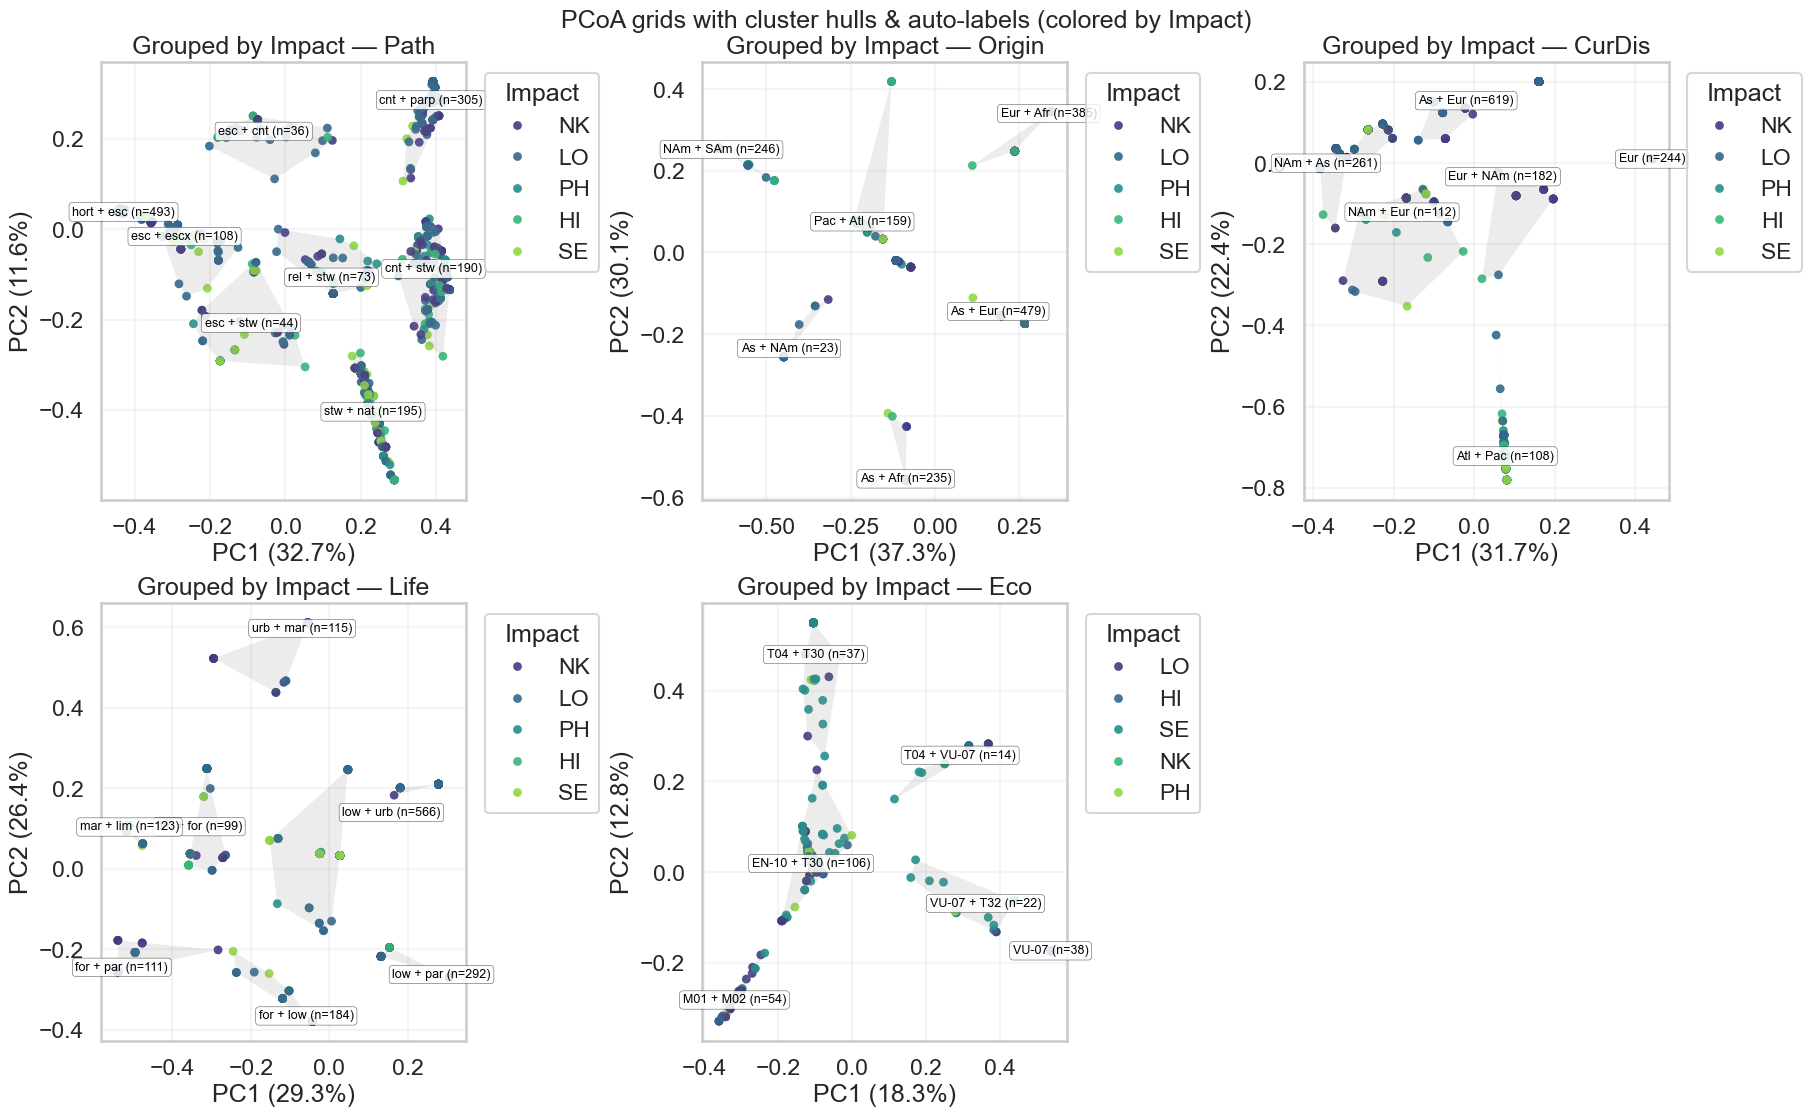

In [ ]:
# ========= Imports =========
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix
from scipy.spatial import ConvexHull, QhullError

sns.set_context("talk")


# ========= Helpers =========
def _block_matrix(df: pd.DataFrame, prefix: str):
    """Return a 0/1 block for columns starting with prefix, after removing empty rows/cols."""
    cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[cols].fillna(0).astype(int).clip(0, 1)
    # drop all-zero rows/cols
    X = X.loc[X.any(axis=1)]
    X = X.loc[:, X.any(axis=0)]
    return X


def _pcoa_jaccard(X: pd.DataFrame):
    """PCoA on Jaccard distance of a binary matrix."""
    D = pairwise_distances(X.values.astype(bool), metric="jaccard")
    dm = DistanceMatrix(D, ids=X.index.astype(str).tolist())
    p = pcoa(dm)
    coords = p.samples.iloc[:, :2].copy()
    coords.columns = ["PC1", "PC2"]
    vx = float(p.proportion_explained["PC1"] * 100)
    vy = float(p.proportion_explained["PC2"] * 100)
    return coords, (vx, vy)


def _best_k(coords: pd.DataFrame, k_range=range(2, 9), random_state=42):
    """Choose k by max silhouette in the 2D PCoA space and return (labels, k, sil)."""
    X = coords[["PC1", "PC2"]].to_numpy()
    best_k, best_s = None, -1
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit(X)
        s = silhouette_score(X, km.labels_)
        if s > best_s:
            best_k, best_s = k, s
    labels = KMeans(n_clusters=best_k, n_init=20, random_state=random_state).fit(X).labels_
    return labels, best_k, best_s


def _top_feature_labels(X_block: pd.DataFrame, labels, top_k=2):
    """Map cluster id -> 'feat1 + feat2' (most prevalent features within cluster)."""
    labnames = {}
    labels = np.asarray(labels)
    for cl in np.unique(labels):
        mask = labels == cl
        mu = X_block.loc[X_block.index[mask]].mean().sort_values(ascending=False)
        mu = mu[mu > 0]
        if mu.empty:
            labnames[cl] = "(no signal)"
            continue
        feats = mu.index[:top_k].tolist()
        clean = [f.split("_", 1)[1].replace("_", " ") if "_" in f else f for f in feats]
        labnames[cl] = " + ".join(clean)
    return labnames


def _add_hulls(ax, coords: pd.DataFrame, labels, color="grey", alpha=0.15):
    """Add convex hulls per cluster (safe for small/degenerate groups)."""
    labels = pd.Series(labels, index=coords.index, name="cl")
    for cl, grp in coords.join(labels).groupby("cl"):
        if grp.shape[0] < 3:
            continue
        try:
            pts = grp[["PC1", "PC2"]].to_numpy()
            hull = ConvexHull(pts)
            poly = pts[hull.vertices]
            ax.fill(poly[:, 0], poly[:, 1], color=color, alpha=alpha, linewidth=0)
        except QhullError:
            continue


def pcoa_block_with_clusters(df: pd.DataFrame, prefix: str, *,
                             hue_col="Impact", palette="viridis",
                             title_prefix=None, k_range=range(2, 9), ax=None):
    """PCoA (Jaccard) of a dummy block, colored by hue_col, with auto clusters & labels."""
    # 1) features
    X = _block_matrix(df, prefix)
    if X.shape[0] < 5 or X.shape[1] < 2:
        raise ValueError(f"Not enough data after filtering for '{prefix}'.")

    # 2) ordination
    coords, (vx, vy) = _pcoa_jaccard(X)

    # 3) align hue with X rows
    hue = df.loc[X.index, hue_col].astype(str)
    plot_df = coords.copy()
    plot_df[hue_col] = hue.values

    # 4) clustering in 2D + readable labels
    labels, k, sil = _best_k(coords, k_range=k_range)
    labnames = _top_feature_labels(X, labels, top_k=2)

    # 5) centroids for labeling
    c_df = coords.copy()
    c_df["label"] = [labnames[cl] for cl in labels]
    centroids = c_df.groupby("label")[["PC1", "PC2"]].mean()
    sizes = c_df.groupby("label").size()

    # 6) plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    sns.scatterplot(ax=ax, data=plot_df, x="PC1", y="PC2",
                    hue=hue_col, palette=palette, s=40, alpha=0.9, edgecolor="none")

    _add_hulls(ax, coords, labels, color="grey", alpha=0.15)

    for lab, (x, y) in centroids.iterrows():
        ax.text(x, y, f"{lab} (n={sizes[lab]})",
                ha="center", va="center", fontsize=9, color="black",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", lw=0.3, alpha=0.85))

    blk = prefix.rstrip("_")
    title = f"PCoA (Jaccard) — {blk}"
    if title_prefix:
        title = f"{title_prefix} {blk}"
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({vx:.1f}%)")
    ax.set_ylabel(f"PC2 ({vy:.1f}%)")
    ax.legend(title=hue_col, loc="upper left", bbox_to_anchor=(1.02, 1))
    ax.grid(True, alpha=0.2)

    return {"coords": coords, "labels": labels, "cluster_names": labnames,
            "k": k, "sil": sil, "var": (vx, vy)}


# ========= Mega grid (colored by Impact) =========
blocks = ["Path_", "Origin_", "CurDis_", "Life_", "Eco_"]
ncols = 3
nrows = int(np.ceil(len(blocks) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5.4 * nrows), constrained_layout=True)
axes = axes.ravel()

results = {}
for i, pref in enumerate(blocks):
    results[pref] = pcoa_block_with_clusters(
        df_ml, pref, hue_col="Impact", palette="viridis",
        title_prefix="Grouped by Impact —", ax=axes[i]
    )

# remove any empty panels
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("PCoA grids with cluster hulls & auto-labels (colored by Impact)",
             y=1.02, fontsize=18)
plt.show()

/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.4993678033351898 whereas the largest positive one is 27.1450138092041.
  warn(


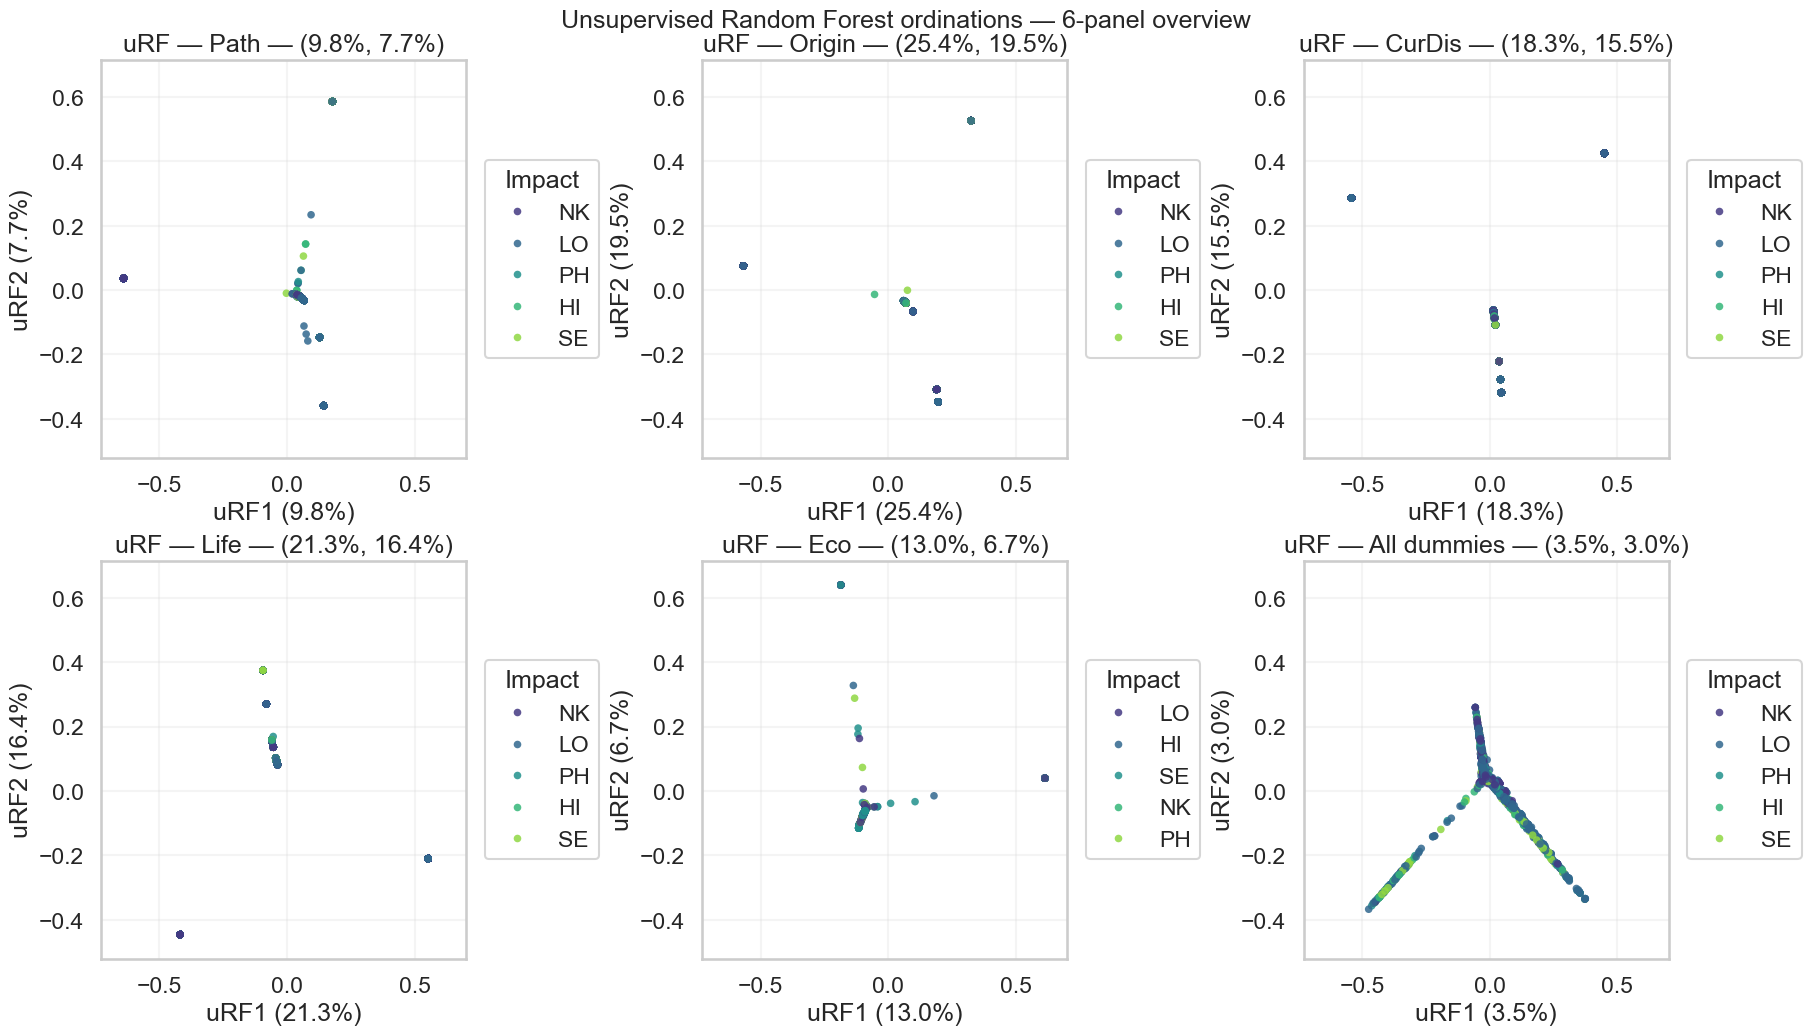

In [ ]:
# === uRF 6-panel ordinations (points only, 1,800 trees, unified axes) ===
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa

sns.set_context("talk")

# ---------------- helpers ----------------
def _block(df, prefixes):
    """Return a 0/1 matrix for any column starting with any of `prefixes`."""
    if isinstance(prefixes, str):
        prefixes = [prefixes]
    cols = [c for c in df.columns if any(c.startswith(p) for p in prefixes)]
    X = df[cols].fillna(0).astype(int).clip(0, 1)
    # drop all-zero rows/cols
    X = X.loc[X.any(axis=1)]
    X = X.loc[:, X.any(axis=0)]
    return X

def _urf_proximity(X, ntree=1800, random_state=42):
    """
    Unsupervised RF proximity (Breiman 2003 trick):
    - train RF classifier to separate real rows vs. row-wise permuted 'noise'
    - proximity = fraction of trees where two real samples end in the same leaf
    """
    n = X.shape[0]
    rng = np.random.RandomState(random_state)
    X_noise = X.apply(lambda col: rng.permutation(col.values))  # column-wise perm
    X_mix = pd.concat([X, X_noise], axis=0).values
    y = np.r_[np.ones(n, dtype=int), np.zeros(n, dtype=int)]

    rf = RandomForestClassifier(
        n_estimators=ntree, max_features="sqrt",
        min_samples_leaf=1, n_jobs=-1, random_state=random_state,
        criterion="gini"
    ).fit(X_mix, y)

    # leaves for the real samples only
    leaves = [estimator.apply(X.values) for estimator in rf.estimators_]
    # accumulate co-occurrence in same leaf across trees
    prox = np.zeros((n, n), dtype=np.float32)
    for leaf in leaves:
        # adjacency where leaf_ids are equal
        same = (leaf[:, None] == leaf[None, :])
        prox += same
    prox /= float(ntree)
    # distance = 1 - proximity
    D = 1.0 - prox
    # small numerical clean-up
    np.fill_diagonal(D, 0.0)
    return D

def _pcoa_from_D(D, ids):
    dm = DistanceMatrix(D, ids=list(map(str, ids)))
    p = pcoa(dm)
    coords = p.samples.iloc[:, :2].copy()
    coords.columns = ["uRF1", "uRF2"]
    vx = float(p.proportion_explained["PC1"] * 100)
    vy = float(p.proportion_explained["PC2"] * 100)
    return coords, (vx, vy)

def _urf_panel(df, prefixes, title, hue_col="Impact", ntree=1800,
               max_points=1500, palette="viridis", ax=None, seed=42):
    """Build one panel: uRF -> PCoA, scatter colored by hue."""
    X = _block(df, prefixes)
    if X.shape[0] < 5 or X.shape[1] < 2:
        # too small after filtering
        if ax is not None:
            ax.set_title(f"{title} — (too few rows/cols)")
            ax.axis("off")
        return None

    # optional thinning for very dense panels (keeps legends readable)
    if X.shape[0] > max_points:
        rng = np.random.RandomState(seed)
        keep = rng.choice(X.index, size=max_points, replace=False)
        X = X.loc[keep]

    D = _urf_proximity(X, ntree=ntree, random_state=seed)
    coords, (vx, vy) = _pcoa_from_D(D, ids=X.index)

    plot_df = coords.copy()
    plot_df[hue_col] = df.loc[X.index, hue_col].astype(str).values

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    sns.scatterplot(
        ax=ax, data=plot_df, x="uRF1", y="uRF2",
        hue=hue_col, palette=palette, s=30, alpha=0.85, edgecolor="none"
    )
    ax.set_title(f"{title} — ({vx:.1f}%, {vy:.1f}%)")
    ax.set_xlabel(f"uRF1 ({vx:.1f}%)")
    ax.set_ylabel(f"uRF2 ({vy:.1f}%)")
    ax.legend(title=hue_col, loc="center left", bbox_to_anchor=(1.02, 0.5))
    ax.grid(True, alpha=0.2)

    return plot_df  # return to harmonize limits later

# ---------------- draw 6 panels ----------------
PANELS = [
    ("Path_",   "uRF — Path"),
    ("Origin_", "uRF — Origin"),
    ("CurDis_", "uRF — CurDis"),
    ("Life_",   "uRF — Life"),
    ("Eco_",    "uRF — Eco"),
    (["Path_", "Origin_", "CurDis_", "Life_", "Eco_"], "uRF — All dummies"),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.ravel()

all_points = []   # collect for unified limits
for ax, (pref, ttl) in zip(axes, PANELS):
    pts = _urf_panel(
        df=df_ml, prefixes=pref, title=ttl, hue_col="Impact",
        ntree=1800, max_points=1800, palette="viridis", ax=ax, seed=42
    )
    if pts is not None:
        all_points.append(pts[["uRF1", "uRF2"]].values)

# unify axes ranges (nice comparison across panels)
if all_points:
    XY = np.vstack(all_points)
    span = XY.max(axis=0) - XY.min(axis=0)
    pad = 0.07 * np.where(span == 0, 1.0, span)
    xlim = (XY[:, 0].min() - pad[0], XY[:, 0].max() + pad[0])
    ylim = (XY[:, 1].min() - pad[1], XY[:, 1].max() + pad[1])
    for ax in axes:
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)

fig.suptitle("Unsupervised Random Forest ordinations — 6-panel overview", fontsize=18, y=1.02)
plt.show()

uRF plots show a ....

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Convert Impact to numeric (if categorical)
impact_map = {'NK': 0, 'LO': 1, 'PH': 2, 'HI': 3, 'SE': 4}
df_ml["Impact_num"] = df_ml["Impact"].map(impact_map)

# X = all dummy variables
X = df_ml[[c for c in df_ml.columns if any(c.startswith(p) for p in ["Path_", "Origin_", "CurDis_", "Life_", "Eco_"])]]
y = df_ml["Impact_num"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y.round())

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=123,
    tree_method="hist"
)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


R² = 0.288, RMSE = 0.995


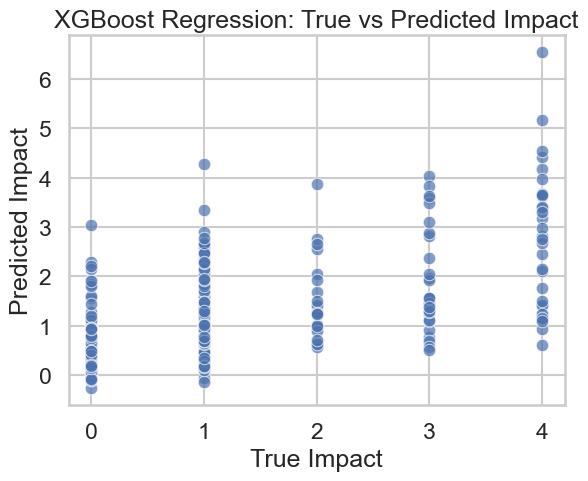

In [ ]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² = {r2:.3f}, RMSE = {rmse:.3f}")

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact")
plt.title("XGBoost Regression: True vs Predicted Impact")
plt.show()

In [ ]:
# Assign higher weights to rare, high-impact classes
weights = y_train.map({0:1.0, 1:1.2, 2:1.5, 3:2.0, 4:2.5})
model.fit(X_train, y_train, sample_weight=weights)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


R² = 0.252, RMSE = 1.020


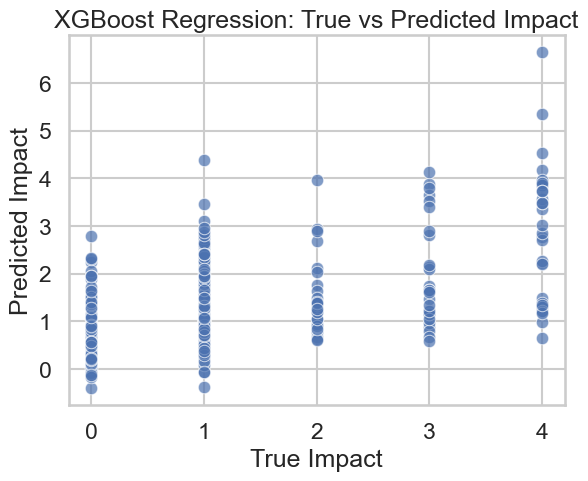

In [ ]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² = {r2:.3f}, RMSE = {rmse:.3f}")

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact")
plt.title("XGBoost Regression: True vs Predicted Impact")
plt.show()

[I 2025-10-07 10:32:13,454] A new study created in memory with name: no-name-da03f0ab-c39e-4889-811a-fcd70d0881e9


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-10-07 10:32:15,601] Trial 0 finished with value: 1.1474940778126537 and parameters: {'n_estimators': 1611, 'max_depth': 4, 'learning_rate': 0.2667337245083204, 'subsample': 0.6291536310597456, 'colsample_bytree': 0.9198986605720523, 'reg_lambda': 0.11847334510129746, 'reg_alpha': 0.1621697711247414, 'min_child_weight': 5}. Best is trial 0 with value: 1.1474940778126537.
[I 2025-10-07 10:32:20,696] Trial 1 finished with value: 1.0320393402452461 and parameters: {'n_estimators': 1973, 'max_depth': 10, 'learning_rate': 0.06704101066082249, 'subsample': 0.9524402068260057, 'colsample_bytree': 0.7694213023555395, 'reg_lambda': 3.1488318827507054, 'reg_alpha': 0.6520048480709348, 'min_child_weight': 5}. Best is trial 1 with value: 1.0320393402452461.
[I 2025-10-07 10:32:23,471] Trial 2 finished with value: 0.9753539885521662 and parameters: {'n_estimators': 1676, 'max_depth': 5, 'learning_rate': 0.07278272891654737, 'subsample': 0.8530421870411543, 'colsample_bytree': 0.6676481209207

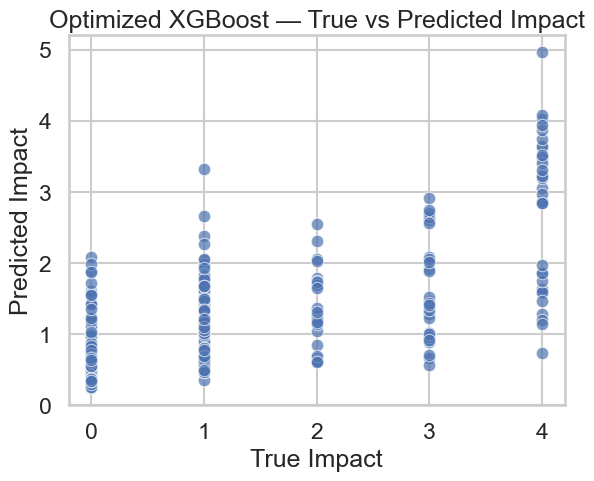

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import xgboost as xgb

# --- prepare data ---
impact_map = {'NK': 0, 'LO': 1, 'PH': 2, 'HI': 3, 'SE': 4}
df_ml["Impact_num"] = df_ml["Impact"].map(impact_map)

X = df_ml[[c for c in df_ml.columns if any(c.startswith(p) for p in ["Path_", "Origin_", "CurDis_", "Life_", "Eco_"])]]
y = df_ml["Impact_num"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y.round()
)

# --- define objective function ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "random_state": 123,
        "n_jobs": -1,
        "tree_method": "hist",
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)

    # Compute RMSE manually (no squared arg)
    rmse = sqrt(mean_squared_error(y_valid, preds))
    return rmse

# --- run optimization ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=80, show_progress_bar=True)

# --- best parameters ---
print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# --- retrain final model ---
best_model = xgb.XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)

# --- evaluate ---
y_pred = best_model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
rmse = sqrt(mean_squared_error(y_valid, y_pred))
print(f"Optimized R² = {r2:.3f}, RMSE = {rmse:.3f}")

sns.scatterplot(x=y_valid, y=y_pred, alpha=0.7)
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact")
plt.title("Optimized XGBoost — True vs Predicted Impact")
plt.show()

Weighted R² = 0.404, RMSE = 0.911


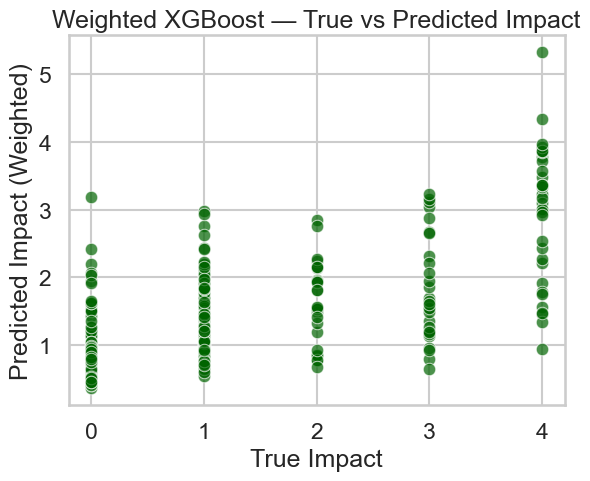

In [ ]:
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error

# Weighted refit
weights = y_train.map({0:1.0, 1:1.2, 2:1.6, 3:2.2, 4:3.0})
best_model.fit(X_train, y_train, sample_weight=weights)

# Predict
y_pred_weighted = best_model.predict(X_valid)

# Evaluate
r2_w = r2_score(y_valid, y_pred_weighted)
rmse_w = sqrt(mean_squared_error(y_valid, y_pred_weighted))
print(f"Weighted R² = {r2_w:.3f}, RMSE = {rmse_w:.3f}")
sns.scatterplot(x=y_valid, y=y_pred_weighted, alpha=0.7, color="darkgreen")
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact (Weighted)")
plt.title("Weighted XGBoost — True vs Predicted Impact")
plt.show()

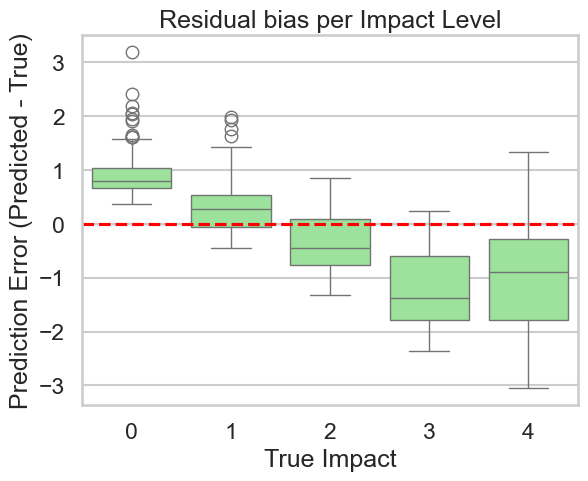

In [ ]:
sns.boxplot(x=y_valid, y=y_pred_weighted - y_valid, color="lightgreen")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Impact")
plt.ylabel("Prediction Error (Predicted - True)")
plt.title("Residual bias per Impact Level")
plt.show()

Weighted R² = 0.365, RMSE = 0.941


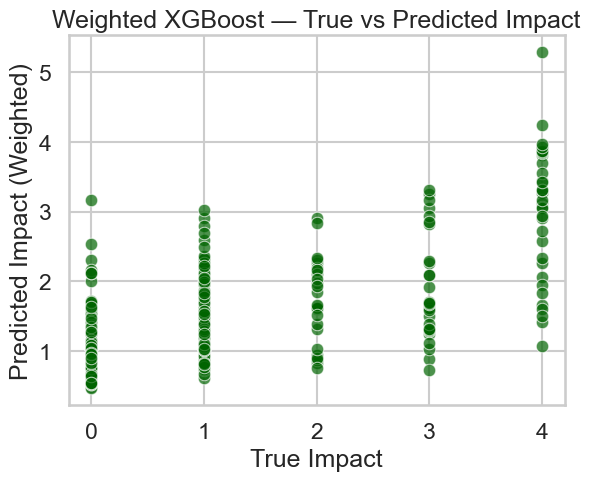

In [ ]:
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error

# Weighted refit
weights = y_train.map({0:0.8, 1:1.2, 2:1.6, 3:2.8, 4:3.5})
best_model.fit(X_train, y_train, sample_weight=weights)

# Predict
y_pred_weighted = best_model.predict(X_valid)

# Evaluate
r2_w = r2_score(y_valid, y_pred_weighted)
rmse_w = sqrt(mean_squared_error(y_valid, y_pred_weighted))
print(f"Weighted R² = {r2_w:.3f}, RMSE = {rmse_w:.3f}")
sns.scatterplot(x=y_valid, y=y_pred_weighted, alpha=0.7, color="darkgreen")
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact (Weighted)")
plt.title("Weighted XGBoost — True vs Predicted Impact")
plt.show()

Text(0, 0.5, 'Residual (Predicted - True)')

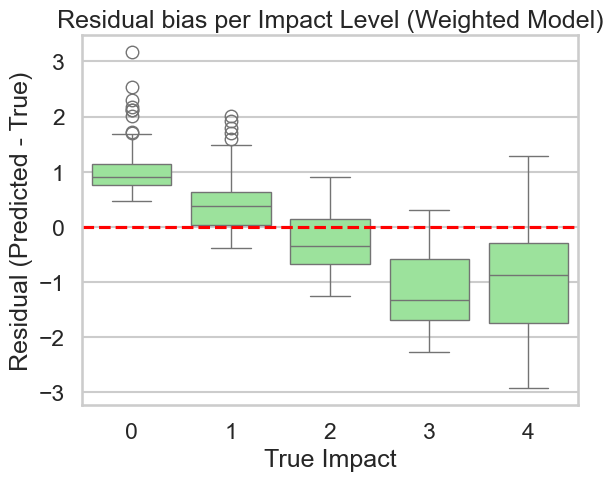

In [ ]:
import seaborn as sns
sns.boxplot(x=y_valid, y=y_pred_weighted - y_valid, color="lightgreen")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual bias per Impact Level (Weighted Model)")
plt.xlabel("True Impact")
plt.ylabel("Residual (Predicted - True)")

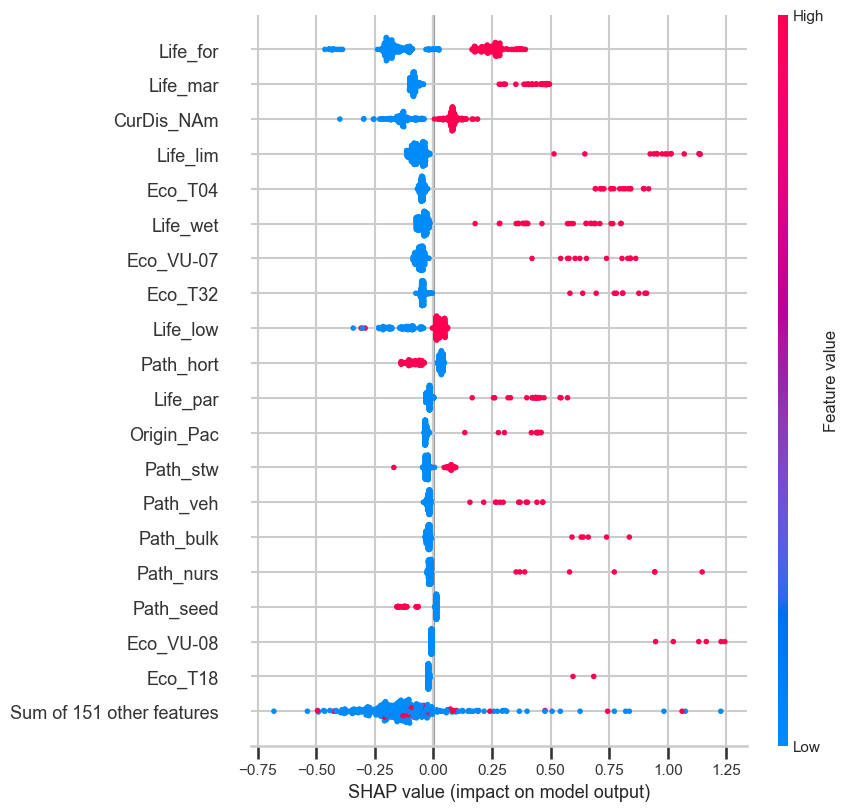

In [ ]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_valid)

shap.plots.beeswarm(shap_values, max_display=20)

this is a commit test

This is a new branch